In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import nibabel as nib
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam

import glob
import time
import yaml
from yaml.loader import SafeLoader
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import pandas as pd
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm

import cv2
from imagen_pytorch3D import Unet, NullUnet, Imagen, SRUnet256, alpha_cosine_log_snr
# from imagen_pytorch import load_imagen_from_checkpoint, ImagenTrainer

from trainer import ImagenTrainer
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import torch.nn.functional as F

from PIL import Image 
import PIL 
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [118]:
x = torch.randn(1,1,32,32,32)
y = torch.randn(1,1,32,32,32)

4

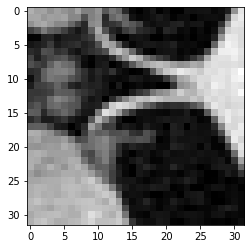

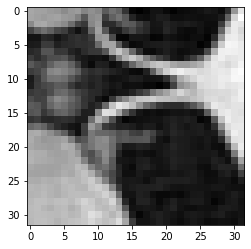

In [117]:
hr = np.load('./results/target.npy')
plt.imshow(hr[0][0][:,16,:],cmap='gray')
plt.show()

hr = np.load('./results/pred.npy')
plt.imshow(hr[0][0][:,16,:],cmap='gray')
plt.show()

In [3]:
lr_files = glob.glob('./HCP3D/valid/*/T1w/lr_norm.nii.gz')
hr_files = glob.glob('./HCP3D/valid/*/T1w/T1w_acpc_dc_restore_brain_sim036T_4x_groundtruth.nii.gz')
hr_files

['./HCP3D/valid\\109830\\T1w\\T1w_acpc_dc_restore_brain_sim036T_4x_groundtruth.nii.gz',
 './HCP3D/valid\\112516\\T1w\\T1w_acpc_dc_restore_brain_sim036T_4x_groundtruth.nii.gz']

In [6]:
x = np.load('./results/figures/conditional_iqt_0_lr.npy')
x.shape

(6, 1, 32, 32, 32)

In [9]:
def cube(data):

    hyp_norm = data

    if len(hyp_norm.shape)>3:
        hyp_norm = hyp_norm[:,:, 2:258, 27:283]
    else:
        hyp_norm = hyp_norm[2:258, 27:283]

    return hyp_norm

def save2patches(lr_files, hr_files, patch_size=32, save_path = './HCP3D/valid_patch/', ratio=0.7):
    for lr_file in lr_files:
        lr = nib.load(lr_file).get_fdata().astype(np.float32)
        hr = nib.load(lr_file.replace('lr_norm', 'T1w_acpc_dc_restore_brain_sim036T_4x_groundtruth')).get_fdata().astype(np.float32)
        fname = lr_file.split('\\')[1]
        if not os.path.isdir(save_path+fname):
            os.makedirs(save_path+fname)
        lr = cube(lr)
        hr = cube(hr)
        print(lr.shape, hr.shape)

        x,y,z = lr.shape
        total_voxel = patch_size**3
        for i in range(0,x-patch_size,patch_size):
            for j in range(0,y-patch_size,patch_size):
                for k in range(0,z-patch_size,patch_size):
                    lr_patch = lr[i:i+patch_size, j: j+patch_size, k: k+patch_size]
                    hr_patch = hr[i:i+patch_size, j: j+patch_size, k: k+patch_size]
                    non_zero = np.count_nonzero(lr_patch)
                    non_zero_proportion = (non_zero/total_voxel)
                    if (non_zero_proportion > ratio):
                        with open(save_path+fname+'/lr_patch_'+str(patch_size)+'_'+str(i)+'_'+str(j)+'_'+str(k)+'.npy', 'wb') as f:
                            np.save(f, lr_patch)
                        with open(save_path+fname+'/hr_patch_'+str(patch_size)+'_'+str(i)+'_'+str(j)+'_'+str(k)+'.npy', 'wb') as f:
                            np.save(f, hr_patch)
save2patches(lr_files, hr_files)

(256, 256, 256) (256, 256, 256)
(256, 256, 256) (256, 256, 256)


In [10]:
def pred(images, imagen, iter):
    lowres_images = images.cuda()  # starting un-resoluted images [1, 3, 64, 64]

    pred = imagen.sample(
        start_at_unet_number = 2,              # start at unet number 2
        start_image_or_video = lowres_images,  # pass in low resolution images to be resoluted
        cond_scale = 1)

    pred.shape # (1, 3, 256, 256)
    # define a transform to convert a tensor to PIL image
    transform = T.ToPILImage()

    # convert the tensor to PIL image using above transform
    img = transform(pred[0])
    img.save(save_path.split('.')[0]+'_iter_{}.png'.format(iter))
    
def evaluate(imagen):
    # do the above for many many many many steps
    # now you can sample an image based on the text embeddings as well as low resolution images

    lowres_images = torch.randn(3, 3, 64, 64).cuda()  # starting un-resoluted images

    images = imagen.sample(
        texts = [
            'a whale breaching from afar',
            'young girl blowing out candles on her birthday cake',
            'fireworks with blue and green sparkles'
        ],
        start_at_unet_number = 2,              # start at unet number 2
        start_image_or_video = lowres_images,  # pass in low resolution images to be resoluted
        cond_scale = 3.)

    images.shape # (3, 3, 256, 256)
    
def np2tensor(x, length, mode='2d'):
    x = torch.tensor(x)
    if mode == '2d':
        if length == 2:
            x = torch.unsqueeze(x,0)
        elif length == 3:
            x = torch.unsqueeze(x,0)
    else:
        if length == 3:
            x = torch.unsqueeze(x,0)
        elif length == 4:
            x = torch.unsqueeze(x,0)
    return x
            

In [11]:
class Dataset(Dataset):
    def __init__(
        self,
        hr_files,
        lr_files,
        fake = False
    ):
        self.hrfiles = hr_files
        self.lrfiles = lr_files
        self.fake = fake
        
        assert len(self.hrfiles) == len(self.hrfiles), "Length should be same"
    
    def transform(self, img, size=(256,256)):
        return TF.resize(img, size)
        
    def normalize(self, img):
        img = (img-img.min())/(img.max()-img.min())
        return img

    def __len__(self):
        return len(self.hrfiles)

    def __getitem__(self, idx):

        if not self.fake:
            hrfile = self.hrfiles[idx]
            lrfile = self.hrfiles[idx].replace('groundtruth_', 'lr_')
            
            hrimg = np.load(hrfile).astype(np.float32)
            hrimg = np2tensor(hrimg, len(hrimg.shape))
            hrimg = self.transform(hrimg)
            hrimg = self.normalize(hrimg)
            
            lrimg = np.load(lrfile).astype(np.float32)
            lrimg = np2tensor(lrimg, len(lrimg.shape))
    #         lrimg = self.transform(lrimg,size=(64,64))
            lrimg = self.transform(lrimg)
            lrimg = self.normalize(lrimg)
        
        else:
            hrimg = torch.randn(1,32,32,32)
            lrimg = torch.randn(1,32,32,32)

        return hrimg, lrimg

In [12]:
hr_files = glob.glob('./HCP2D/train/*/groundtruth_*.npy')
lr_files = glob.glob('./HCP2D/train/*/lr_*.npy')
batch_size = 2

print(len(hr_files), len(lr_files))
train_dataset = Dataset(hr_files, lr_files, fake=True)
train_loader =  DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
data = next(iter(train_loader))
len(train_loader)
data[0].shape
# cnt = 10
# for i,data in enumerate(train_loader):
#     print(i)
#     plt.imshow(data[0][0][0],cmap='gray')
#     plt.show()
#     plt.imshow(data[1][0][0],cmap='gray')
#     plt.show()
#     if i == cnt:
#         break

146 146


torch.Size([2, 1, 32, 32, 32])

In [13]:
hr_files_test = glob.glob('./HCP2D/test/*/groundtruth_*.npy')
lr_files_test = glob.glob('./HCP2D/test/*/lr_*.npy')
batch_size = 1

print(len(hr_files), len(lr_files))
valid_dataset = Dataset(hr_files_test, lr_files_test, fake=True)
valid_loader =  DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
data = next(iter(valid_loader))
len(valid_loader)
data[0].shape
# cnt = 10
# for i,data in enumerate(valid_loader):
#     print(i)
#     plt.imshow(data[0][0][0],cmap='gray')
#     plt.show()
#     plt.imshow(data[1][0][0],cmap='gray')
#     plt.show()
#     if i == cnt:
#         break

146 146


torch.Size([1, 1, 32, 32, 32])

In [14]:
# unet for imagen
unet1 = NullUnet()

unet2 = SRUnet256(
    dim = 32,
    dim_mults = (1, 4, 8), #(1, 2, 4, 8),
    channels=1,
    num_resnet_blocks = (2, 4, 8),#(2, 4, 8, 8),
    layer_attns = (False, False, True),
    layer_cross_attns = False,
    cond_on_text =False
)

imagen = Imagen(
    condition_on_text = False, 
    unets = (unet1, unet2),
    image_sizes = (8, 32),
    channels=1,
    timesteps = 500,
    cond_drop_prob = 0.0
).to(device)

trainer = ImagenTrainer(
    imagen = imagen,
    #cosine_decay_max_steps = len(train_loader)*10,
    split_valid_from_train = False # whether to split the validation dataset from the training
)

trainer.add_train_dataset(train_dataset, batch_size = batch_size)
trainer.add_valid_dataset(valid_dataset, batch_size = 1)

unet2.eval()

The base dimension of your u-net should ideally be no smaller than 128, as recommended by a professional DDPM trainer https://nonint.com/2022/05/04/friends-dont-let-friends-train-small-diffusion-models/


SRUnet256(
  (init_conv): CrossEmbedLayer(
    (convs): ModuleList(
      (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): Conv3d(1, 8, kernel_size=(7, 7, 7), stride=(1, 1, 1), padding=(3, 3, 3))
      (2): Conv3d(1, 8, kernel_size=(15, 15, 15), stride=(1, 1, 1), padding=(7, 7, 7))
    )
  )
  (to_time_hiddens): Sequential(
    (0): LearnedSinusoidalPosEmb()
    (1): Linear(in_features=17, out_features=128, bias=True)
    (2): SiLU()
  )
  (to_time_cond): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (to_time_tokens): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Rearrange('b (r d) -> b r d', r=2)
  )
  (norm_cond): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (init_resnet_block): ResnetBlock(
    (time_mlp): Sequential(
      (0): SiLU()
      (1): Linear(in_features=128, out_features=64, bias=True)
    )
    (block1): Block(
      (groupnorm): GroupNorm(8, 32, eps=

In [9]:
test_img = torch.randn(1,1,32,32,32)
outputs = trainer.sample(batch_size = 1, return_all_unet_outputs = True, return_pil_images = False, start_image_or_video = test_img.to(device), start_at_unet_number = 2) # returns List[Image]

unet 2 has not been trained
when sampling, you can pass stop_at_unet_number to stop early in the cascade, so it does not try to generate with untrained unets


2it [00:22, 11.09s/it]


In [7]:
train_ls = []
for i in range(2):
    print(i)
    loss = trainer.train_step(unet_number = 2, max_batch_size = 2)
    train_ls.append(loss)
    trainer.update(unet_number = 2)
    
valid_loss, preds, data = trainer.valid_step(unet_number = 2, max_batch_size = 2)
valid_loss = np.mean(valid_loss)
train_ls = np.mean(np.array(train_ls))

print("Loss: {} {}".format(train_ls, valid_loss))

0
1


2it [00:25, 12.69s/it]
2it [00:24, 12.28s/it]
2it [00:24, 12.42s/it]
2it [00:26, 13.46s/it]
2it [00:25, 12.78s/it]
2it [00:26, 13.29s/it]
2it [00:26, 13.02s/it]
2it [00:25, 12.91s/it]
2it [00:25, 12.88s/it]
2it [00:25, 12.54s/it]
2it [00:25, 12.60s/it]
2it [00:25, 12.62s/it]


ValueError: too many values to unpack (expected 2)

In [ ]:
# working training loop
train_ls = []
valid_ls = []
lst_best = 0
best = 100
for i in range(20000):
    loss = trainer.train_step(unet_number = 2, max_batch_size = 2)
    train_ls.append(loss)
    train_loss_save = pd.DataFrame({'loss': train_ls}).to_csv(os.getcwd()+('/train_loss.csv'), index=False)
    trainer.update(unet_number = 2)
    if not (i % 50):
        print(f'unet: 2, Epoch: {i}, loss: {loss}')
        valid_loss, preds = trainer.valid_step(unet_number = 2, max_batch_size = 2)
        valid_loss = np.mean(valid_loss)
        valid_ls.append(valid_loss)
        valid_loss_save = pd.DataFrame({'loss': valid_ls}).to_csv(os.getcwd()+('/valid_loss.csv'), index=False)
        print(f'valid loss: {valid_loss}')
        if best > valid_loss:
            print("Best model!")
            best = valid_loss
            for j in range(len(preds)):
                preds[j][0][0].save('./results/figures/'+f'conditional_iqt_{j}_pred.png')
            trainer.save('./results/model/checkpoint.pt')
trainer.save('./results/model/last_checkpoint.pt')

In [ ]:
plt.plot(train_ls, label='train')
plt.legend()
plt.show()

In [ ]:
plt.plot(valid_ls, label='valid')
plt.legend()
plt.show()

# Evaluation

In [ ]:
trainer.load('./results/model/checkpoint.pt');

In [ ]:
images, outputs, lst = trainer.sample(batch_size = 1, return_all_unet_outputs = True, return_pil_images = True, start_image_or_video = test_img.to(device), start_at_unet_number = 2) # returns List[Image]
ls = F.l1_loss(test_img2, outputs[0].cpu())
print("Test loss: ",ls)

In [ ]:
lst2 = []
for i in range(len(lst)):
    if (i % 20 == 0) or (i == len(lst)-1):
        lst2.append(lst[i][0,0].cpu().numpy())
        
plt.imshow(test_img[0,0].cpu().numpy(), cmap='gray')
plt.title("Input".format(i))
plt.show()
plt.imshow(outputs[-1][0,0].cpu().numpy(), cmap='gray')
plt.title("Time Step: {}".format(i))
plt.show()

In [ ]:
# idx = torch.where(test_img2==0)
# img = lst[-1].cpu()+1
# img[idx] = 0
# img.shape

In [ ]:
fig, ax = plt.subplots()

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(len(lst2)):
    im = ax.imshow(lst2[i],cmap='gray', animated=True)
    title = ax.text(70, -10, f'Timestep: {i*20}', fontsize=15, bbox={'facecolor': 'blue',
                                       'alpha': 0.5, 'pad': 5})
    if i == 0:
        ax.imshow(lst2[i],cmap='gray')  # show an initial one first
    ims.append([im,title])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=5000)

# To save the animation, use e.g.
#
ani.save("movie.mp4")

plt.show()

In [ ]:
plt.imshow(test_img[0][0],cmap='gray')